In [1]:
import argparse
import logging
import random
import time
import datetime

from sklearn.metrics import f1_score
from torch import optim, nn
from torch.utils.data import DataLoader

from data_helpers import *
from model_temporal import TemporalClassificationModel
import matplotlib.pyplot as plt

Matplotlib created a temporary config/cache directory at /scratch/207548/matplotlib-rx6z0tx0 because the default path (/home/beck/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# variables

label_maps = {
    'debate': {'claim': 1, 'noclaim': 0},
    'sandy': {'y': 1, 'n': 0},
    'rumours':  {'comment': 0, 'deny': 1, 'support': 2, 'query': 3},
    'clex': {'Related - but not informative': 0, 'Not related': 1,
             'Related and informative': 2, 'Not applicable': 3}
}

label_maps_inverse = {
    'debate': {1: 'claim', 0: 'noclaim'},
    'sandy': {1: 'y', 0:'n'},
    'rumours':  {0: 'comment', 1: 'deny', 2:'support', 3:'query'},
    'clex': {0: 'Related - but not informative', 1: 'Not related',
             2: 'Related and informative', 3:'Not applicable'}
}

data_name = 'sandy'
data_dir = '/ukp-storage-1/beck/Repositories/temporal-adaptation/datasets/stowe-2018/labeled/stowe-2018-labeled-all.csv'
partition = 'time_stratified_partition'
results_dir = '/ukp-storage-1/beck/Repositories/dcwe/results/jupyter'
batch_size = 32
lr = 0.0001
n_epochs = 1
lambda_a = 0.1
lambda_w = lambda_a / 0.001
lm_model = 'bert-base-cased'
time_field = 'date'
label_field = 'tag'

In [3]:
dataframe = pd.read_csv(data_dir, parse_dates=[time_field], encoding='utf-8')
nr_classes = len(set(dataframe[label_field].values))
begin_date = dataframe[time_field].min().to_pydatetime().date()
task_label_map = label_maps[data_name]
inverse_task_label_map = label_maps_inverse[data_name]

In [4]:
train_dataset = TemporalClassificationDataset(data_name, dataframe, 'train', begin_date=begin_date,
                                                  partition=partition, label_mapping=task_label_map,
                                                  label_field=label_field, time_field=time_field, lm_model=lm_model)
dev_dataset = TemporalClassificationDataset(data_name, dataframe, 'dev', begin_date, partition=partition,
                                                label_mapping=task_label_map,
                                                label_field=label_field, time_field=time_field, lm_model=lm_model)

Token indices sequence length is longer than the specified maximum sequence length for this model (5295 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1953 > 512). Running this sequence through the model will result in indexing errors


In [5]:
collator = TemporalClassificationCollator()
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collator)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, collate_fn=collator)
device = torch.device('cuda:{}'.format(0) if torch.cuda.is_available() else 'cpu')
model = TemporalClassificationModel(
        #n_times=train_dataset.n_times,
        n_times=max(train_dataset.times + dev_dataset.times) + 1,
        # we have to use the test_dataset here because we do a temporal split and the oldest dates are in the test split
        nr_classes=nr_classes,
        lm_model=lm_model
    )

In [6]:
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
model = model.to(device)
vocab_filter = train_dataset.filter_tensor.to(device)

In [7]:
def compute_loss(data_loader, model, vocab_filter, criterion, lambda_a, lambda_w):
    full_loss = 0
    y_true = list()
    y_pred = list()
    for batch in data_loader:
        labels, times, years, months, days, reviews, masks, segs = batch

        labels = labels.to(device)
        reviews = reviews.to(device)
        masks = masks.to(device)
        segs = segs.to(device)

        offset_t0, offset_t1, output = model(reviews, masks, segs, times, vocab_filter)

        loss = criterion(output, labels.long().view(-1))
        # print('Loss before offsetting: {:.5f}'.format(loss))
        loss += lambda_a * torch.norm(offset_t1, dim=-1).pow(2).mean()
        # print('Loss after offsetting: {:.5f}'.format(loss))
        loss += lambda_w * torch.norm(offset_t1 - offset_t0, dim=-1).pow(2).mean()
        full_loss += loss
        y_true.extend(labels.tolist())
        y_pred.extend(torch.argmax(output, axis=-1).tolist())
    f1_bin = f1_score(y_true, y_pred)
    return full_loss, f1_bin

In [8]:
# model training
train_losses = []
val_losses = []
train_f1s = []
val_f1s = []
steps = []
for epoch in range(1, n_epochs + 1):

    model.train()

    #filename = 'dcwe_{}_{}_losses_epoch_{}'.format(args.data_name, args.partition, str(epoch))
    nr_batches = len(train_loader)
    for i, train_batch in enumerate(train_loader):
        if i % 10 == 0:
            print('Processed {} examples...'.format(i * batch_size))

        labels, times, years, months, days, reviews, masks, segs = train_batch

        labels = labels.to(device)
        reviews = reviews.to(device)
        masks = masks.to(device)
        segs = segs.to(device)

        optimizer.zero_grad()

        offset_t0, offset_t1, output = model(reviews, masks, segs, times, vocab_filter)

        loss = criterion(output, labels.long().view(-1))
        # print('Loss before offsetting: {:.5f}'.format(loss))
        loss += lambda_a * torch.norm(offset_t1, dim=-1).pow(2).mean()
        # print('Loss after offsetting: {:.5f}'.format(loss))
        loss += lambda_w * torch.norm(offset_t1 - offset_t0, dim=-1).pow(2).mean()
        # print('Loss after offsetting diff: {:.5f}'.format(loss))
        loss.backward()

        optimizer.step()
        
        if i % 10 == 0:
            model.eval()
            steps.append(i + nr_batches*(epoch-1))
            with torch.no_grad():
                train_loss, train_f1 = compute_loss(train_loader, model, vocab_filter, criterion, lambda_a, lambda_w)
                train_losses.append(train_loss)
                train_f1s.append(train_f1)
                val_loss, val_f1 = compute_loss(dev_loader, model, vocab_filter, criterion, lambda_a, lambda_w)
                val_losses.append(val_loss)
                val_f1s.append(val_f1)


Processed 0 examples...
Processed 320 examples...
Processed 640 examples...
Processed 960 examples...
Processed 1280 examples...
Processed 1600 examples...
Processed 1920 examples...
Processed 2240 examples...
Processed 2560 examples...
Processed 2880 examples...
Processed 3200 examples...
Processed 3520 examples...
Processed 3840 examples...
Processed 4160 examples...
Processed 4480 examples...
Processed 4800 examples...
Processed 5120 examples...
Processed 5440 examples...
Processed 5760 examples...
Processed 6080 examples...
Processed 6400 examples...
Processed 6720 examples...
Processed 7040 examples...
Processed 7360 examples...
Processed 7680 examples...
Processed 8000 examples...
Processed 8320 examples...
Processed 8640 examples...
Processed 8960 examples...
Processed 9280 examples...
Processed 9600 examples...
Processed 9920 examples...
Processed 10240 examples...


In [9]:
train_values = [i.item() for i in train_losses]
val_values = [i.item() for i in val_losses]


In [10]:
def visualize_train_val(train_values, loss_values):
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(loss_values,label="val")
    plt.plot(train_values,label="train")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

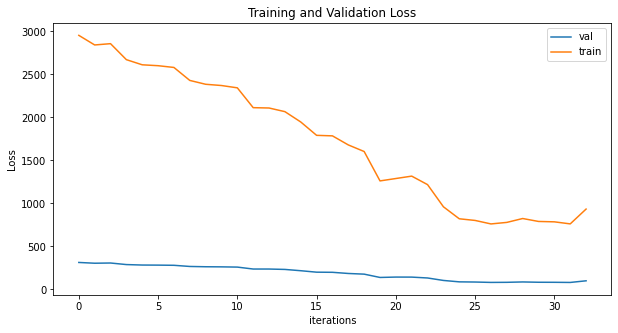

In [11]:
visualize_train_val(train_f1s, val_values)

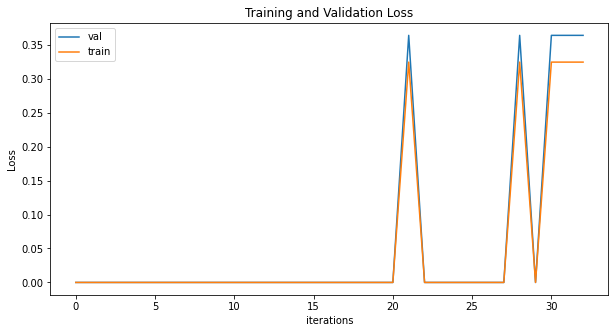

In [13]:
visualize_train_val(train_f1s, val_f1s)